## The spectograms for the DC lightbox test are in IN[410] 
-Ameya

In [404]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib nbagg
from scipy import signal
import mpl_toolkits.mplot3d.art3d as art3d
from astropy.stats import sigma_clip
import traceback
from datetime import *
import warnings
warnings.filterwarnings('ignore')
from scipy.fft import *

Populating the interactive namespace from numpy and matplotlib


In [405]:
#Our Flight Data Processing
numline=0
data=list() #supposedly supposed to be more efficient
with open("data_photo4-10-22.txt",'r') as dataF:
    for line in dataF:
        #print(line)
        time=line[0:line.index(':')]
        vals=line[line.index('[')+1:line.index(']')]
        sepVals=vals.split()
        sepVals.insert(0,time)
        #print(sepVals)
        data.append(sepVals)
        numline+=1
print(len(data))
print(numline)

removed = 0
for x in data:
    if(len(x)>5):
        print(x)
        data.remove(x)
        removed+=1
print(removed)

df=pd.DataFrame(data,columns = ['millis','LS1', 'LS2', 'LS3','LS4'])

dels=0
finished=True
while(finished):
    try:
        df['millis']=pd.to_numeric(df['millis'])
        df['LS1']=pd.to_numeric(df['LS1'])
        df['LS2']=pd.to_numeric(df['LS2'])
        df['LS3']=pd.to_numeric(df['LS3'])
        df['LS4']=pd.to_numeric(df['LS4'])
    except:
        #print(traceback.format_exc())
        num=traceback.format_exc().split() 
        df=df.drop(int(num[-1])+dels,axis="index")
        dels+=1
        print(num[-1])   
    else:
        finished=False;
print(dels)

def convertEpochTimeFromUTC(y,mo,d,h,mi,s):
    t= datetime(y,mo,d,hour=h,minute=mi,second=s,tzinfo=timezone.utc)
    return int(t.timestamp()*1000)
convertEpochTimeFromUTC(2022,4,10,16,42,31)

endUnixTime=convertEpochTimeFromUTC(2022,4,10,16,41,28)
startUnixTime=convertEpochTimeFromUTC(2022,4,10,15,32,13)
dfUseful=df[np.logical_and(df['millis']>startUnixTime,df['millis']<endUnixTime)]

dfnonzero=dfUseful[dfUseful['LS1']>0]
dfnonzero=dfnonzero.reset_index()
dfnonzero["millis"]=(dfnonzero["millis"]-dfnonzero["millis"].iloc[0])/1E3

2643301
2643301
['1649601550269', '0.02057493', '1.111649287814493:', '[', '0.00863969', '1.12391783', '3.03819097', '1.27963677']
['1649610530841', '1.43380361', '0.79539487', '2.5701649607427125:', '[', '0.', '0.', '0.', '0.']
2
84028
101044
2611674
3


In [406]:
"""
Test Data Processing
"""
data_01 = pd.read_csv('https://raw.githubusercontent.com/AmeVel2040/myPiFiles/main/LSStuffAmeya/14-06-22at01-28PM')
startT=data_01.columns[0]
data_01=data_01.drop(columns=['d1','d2','d3'])
data_01.columns = ["Time","d0"]
print(startT)
print(data_01)
xfull,yfull = data_01.iloc[:,0].values/1E6, data_01.iloc[:,1].values
#x,y=xfull,yfull


1655242085556488
           Time        d0
0         22184  0.775999
1         53800  0.778213
2         80215  0.788714
3        105129  0.777429
4        130849  0.790678
...         ...       ...
3504  123117672  0.651944
3505  123142948  0.661558
3506  123167837  0.654079
3507  123213428  0.668784
3508  123239706  0.659662

[3509 rows x 2 columns]


In [407]:
x,y=dfnonzero.iloc[:,1].values, dfnonzero.iloc[:,2].values

           Time        d0    tdiff
0         22184  0.775999      NaN
1         53800  0.778213  31616.0
2         80215  0.788714  26415.0
3        105129  0.777429  24914.0
4        130849  0.790678  25720.0
...         ...       ...      ...
3504  123117672  0.651944  24690.0
3505  123142948  0.661558  25276.0
3506  123167837  0.654079  24889.0
3507  123213428  0.668784  45591.0
3508  123239706  0.659662  26278.0

[3509 rows x 3 columns]
           Time        d0    tdiff
0         22184  0.775999      NaN
1         53800  0.778213  31616.0
2         80215  0.788714  26415.0
3        105129  0.777429  24914.0
4        130849  0.790678  25720.0
...         ...       ...      ...
3504  123117672  0.651944  24690.0
3505  123142948  0.661558  25276.0
3506  123167837  0.654079  24889.0
3507  123213428  0.668784  45591.0
3508  123239706  0.659662  26278.0

[3502 rows x 3 columns]
0.03267300885461297


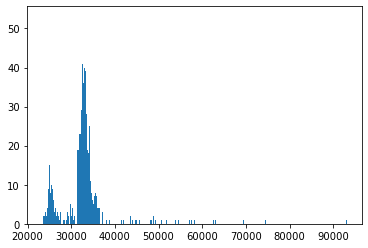

In [408]:
data_01["tdiff"]=data_01['Time'] - data_01['Time'].shift(1)
print(data_01)
data_01=data_01.drop(data_01[(data_01["tdiff"]>100000)].index)
print(data_01)
plt.hist(data_01["tdiff"],bins=2000)
print(data_01["tdiff"].mean()/1E6)

In [439]:
def three_sigmad(nt,nv,chunks,numSigma,progress):
    data = np.row_stack((nt,nv))
    out = np.copy(data)
    i=0
    size=round(data.shape[1]/chunks)
    deleted=0
    while i < chunks:
        chunk = data[:, i*size:(i+1)*size]
        if(i%progress==0):
            print(i)
        #print(chunk.shape)
        lower_bound = chunk[1,:].mean() - numSigma * np.std(chunk[1,:],ddof=1)
        upper_bound = chunk[1,:].mean() + numSigma * np.std(chunk[1,:],ddof=1)
        for x in range(chunk.shape[1]):
            if chunk[1,x] >= upper_bound or chunk[1,x] <= lower_bound:
                #print("True")
                out=np.delete(out,x+i*size-deleted,axis=1)
                deleted+=1

        i+=1
    print(deleted)
    return out[0,:],out[1,:]

def genthePlots(x,y,start,fs,fs2,chunks,numSigma,pr):

    tchunk1=x[start:-1]
    vchunk1=y[start:-1] #OFF
    print(tchunk1.shape)
    print(vchunk1.shape)
    
    normv=(vchunk1-vchunk1.min())/(vchunk1.max()-vchunk1.min())
    z=np.polyfit(tchunk1,normv,deg=2)
    p=np.poly1d(z)
    xp=np.linspace(min(tchunk1),max(tchunk1),len(tchunk1))
    yp=p(xp)
    div=vchunk1/yp
    plt.plot(tchunk1,normv)
    plt.plot(xp,yp)
    plt.show()
    plt.plot(xp,div)
    plt.show()
    print(p)
    
    
        
    newt, newv=three_sigmad(xp,div,chunks,numSigma,pr)
    plot(newt,newv)
    plt.show()
    unnormv=newv*p(newt)
    plt.plot(newt,unnormv)
    plt.show
    
    fclip, tclip, Sxxclip = signal.spectrogram(unnormv, fs,nperseg=256)
    fclip2, tclip2, Sxxclip2 = signal.spectrogram(unnormv, fs2,nperseg=256)
    print(Sxxclip)
    
    fig, axs = plt.subplots(2, 1,figsize=(12,10))
    s_22 = axs[0].pcolormesh(tclip, fclip, Sxxclip,cmap='binary',vmin=min(Sxxclip[0]),vmax=max(Sxxclip[0]))
    axs[0].set_ylim(0,100)
    axs[0].set_xticklabels([24*i for i in range(6)])
    axs[0].set_ylabel('Frequency [Hz]')
    axs[0].set_xlabel('Time [s]')

    s_22 = axs[1].pcolormesh(tclip2, fclip2, Sxxclip2,cmap='binary',vmin=min(Sxxclip2[0]),vmax=max(Sxxclip2[0]))
    axs[1].set_ylim(0,10)
    axs[1].set_xticklabels([24*i for i in range(6)])
    axs[1].set_ylabel('Frequency [Hz]')
    axs[1].set_xlabel('Time [s]')

## Plots for the DC lightbox test

(3408,)
(3408,)


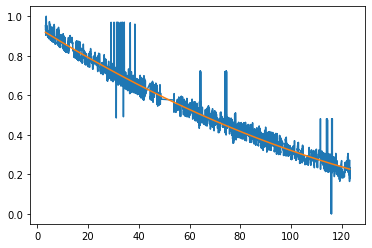

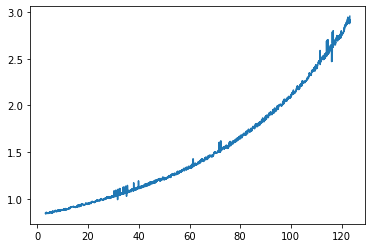

           2
1.755e-05 x - 0.007986 x + 0.9439
0
97


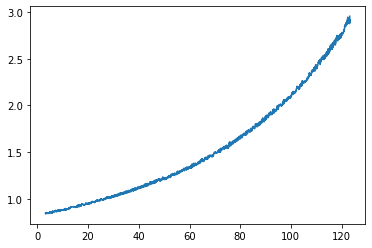

[[8.41104394e-09 8.03502009e-08 1.36134111e-09 ... 1.72371105e-08
  1.88741899e-08 1.30881177e-09]
 [6.59472704e-06 3.79966819e-06 1.88062406e-06 ... 2.58365787e-06
  1.09766353e-06 2.54378853e-06]
 [8.64119742e-07 2.20443961e-06 1.37925472e-07 ... 2.74852472e-07
  3.81875330e-07 2.90220515e-07]
 ...
 [1.12340246e-07 3.18252610e-08 9.46296129e-09 ... 3.22985140e-10
  1.13776173e-07 1.39169418e-07]
 [1.11704450e-07 9.87613538e-09 4.50539061e-09 ... 1.37579871e-09
  4.55882019e-08 7.78834300e-08]
 [6.85772226e-08 1.86256888e-08 1.10848152e-08 ... 4.58496646e-09
  3.04933786e-08 2.10610914e-08]]


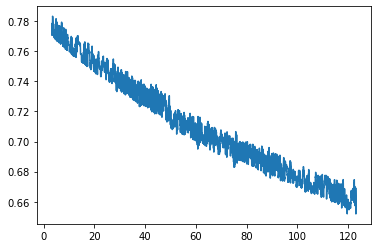

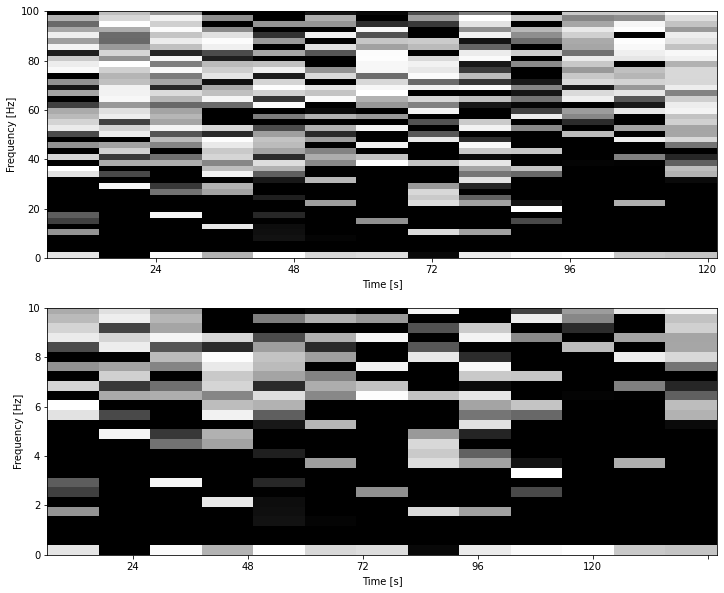

In [440]:
#Scroll to bottom for spectogram
genthePlots(xfull,yfull,100,600,100,125,2,126)

# Below are the same plots for our flight data

(1059846,)
(1059846,)


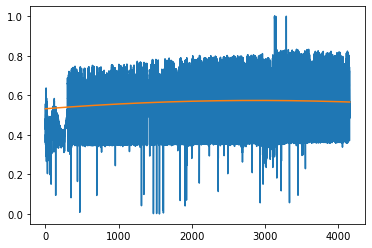

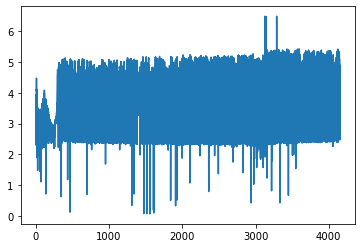

            2
-5.019e-09 x + 2.904e-05 x + 0.532
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
33157


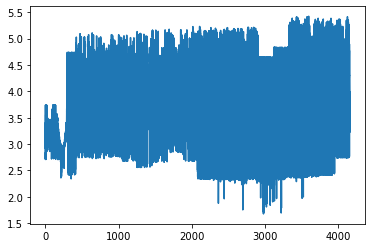

[[1.17644760e-04 2.90566116e-06 2.39327831e-05 ... 6.26172625e-07
  9.75259049e-07 2.99131086e-05]
 [2.82895401e-03 1.29854253e-04 5.05195041e-04 ... 1.09216861e-03
  1.07335240e-03 2.87763764e-04]
 [1.86678171e-03 2.12978304e-04 1.04109083e-04 ... 1.44784773e-04
  1.96257959e-04 1.73189496e-06]
 ...
 [2.63830089e-05 4.16735598e-06 1.44079831e-05 ... 1.66144108e-08
  4.88397127e-09 3.85278019e-09]
 [1.75626559e-05 3.04774878e-06 5.05236582e-06 ... 3.42884029e-08
  1.40591000e-08 1.04799720e-08]
 [1.95082327e-05 3.93294425e-06 9.95673813e-06 ... 1.11485073e-08
  4.54507683e-11 1.26236820e-09]]


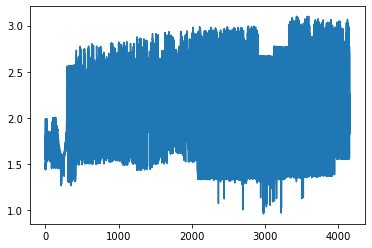

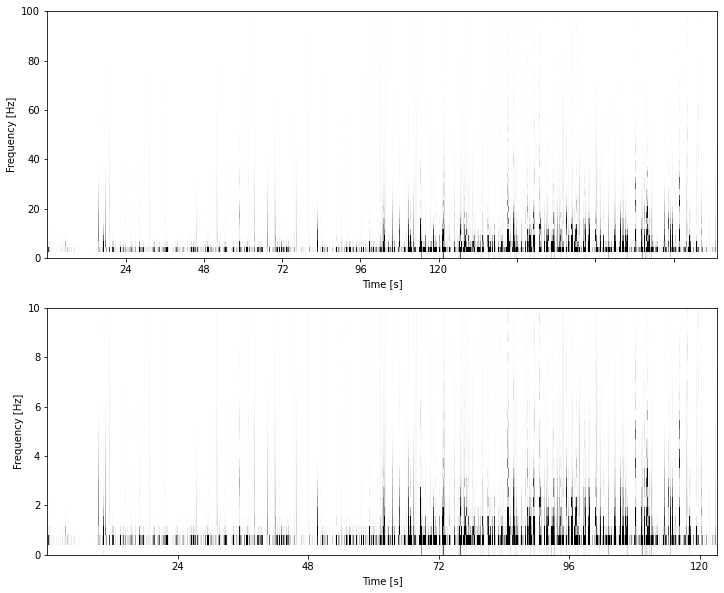

In [445]:
genthePlots(dfnonzero.iloc[:,1].values,dfnonzero.iloc[:,2].values,0,600,100,20,2,1)

(1059846,)
(1059846,)


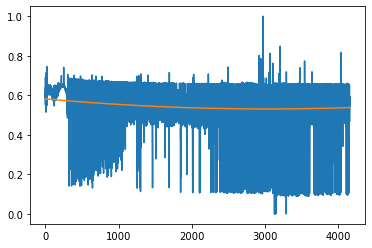

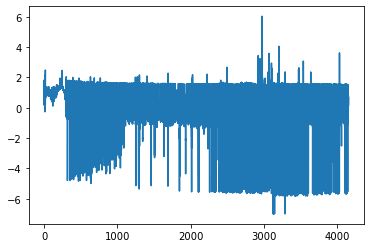

           2
5.577e-09 x - 3.38e-05 x + 0.5821
0
2
4
6
8
10
12
14
16
18
40558


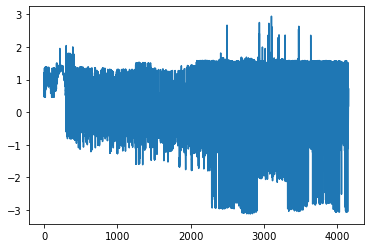

[[1.27915714e-04 3.35812519e-05 1.84489188e-05 ... 6.11048216e-07
  1.14750226e-06 3.17401241e-05]
 [3.63511100e-05 6.40625754e-04 7.70555072e-04 ... 1.00691147e-03
  1.15124025e-03 2.84482114e-04]
 [1.15109335e-03 3.22872346e-05 4.94391345e-04 ... 1.42083338e-04
  2.10701507e-04 2.54990474e-06]
 ...
 [1.74805837e-09 3.91128452e-11 8.42977829e-10 ... 2.85375404e-10
  1.88692101e-10 1.59254872e-09]
 [3.23645862e-09 1.28462123e-10 8.07042832e-10 ... 2.25048040e-10
  1.44418192e-10 9.45780222e-10]
 [1.46764774e-09 5.76070849e-11 3.16086328e-10 ... 4.56695126e-13
  4.27539348e-11 7.77779947e-10]]


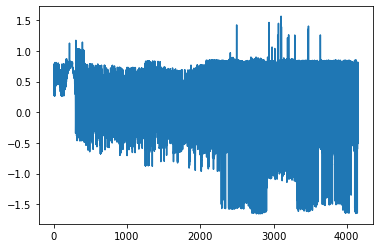

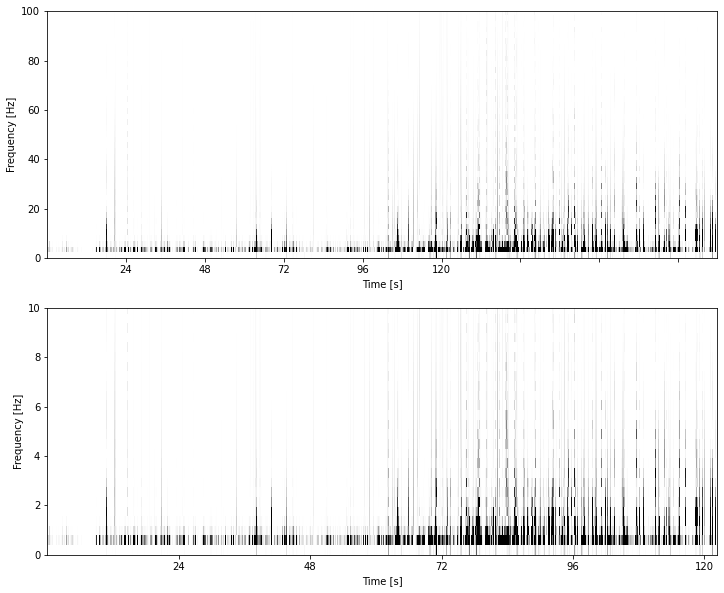

In [446]:
genthePlots(dfnonzero.iloc[:,1].values,dfnonzero.iloc[:,3].values,0,600,100,20,2,2)

(1059846,)
(1059846,)


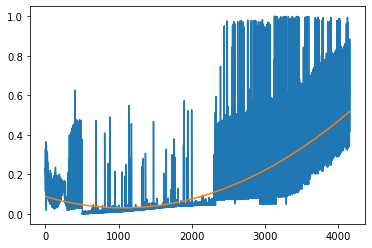

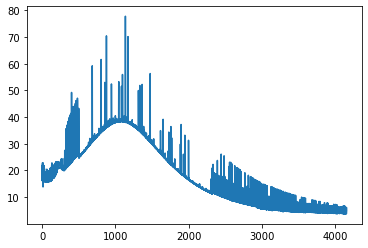

           2
5.083e-08 x - 0.0001076 x + 0.08775
0
2
4
6
8
10
12
14
16
18
27091


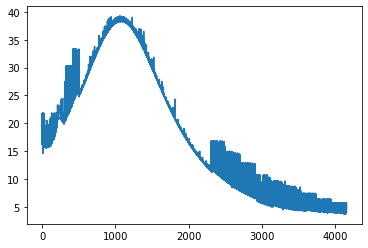

[[8.44022525e-05 1.07025457e-07 1.20658647e-05 ... 3.57009461e-09
  2.56355362e-06 1.43260086e-05]
 [1.93215327e-03 3.87906923e-04 1.95891128e-03 ... 5.79655456e-04
  7.15622175e-05 3.46792145e-03]
 [2.09020006e-03 6.62995927e-04 1.83089183e-04 ... 6.10209026e-05
  2.09406272e-05 8.43019508e-04]
 ...
 [2.40416471e-10 3.53165697e-10 1.39538082e-10 ... 5.12132934e-10
  4.83605194e-09 7.11064880e-08]
 [1.19279600e-10 1.31737236e-10 8.03891757e-11 ... 2.09009764e-10
  2.82274898e-09 3.96505200e-08]
 [3.53558414e-10 9.23962628e-13 1.35594294e-15 ... 2.87170916e-11
  1.32907207e-09 1.46951148e-08]]


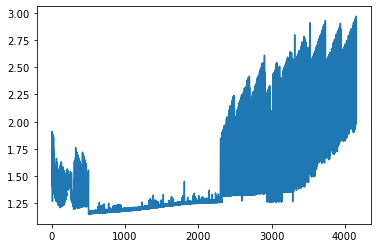

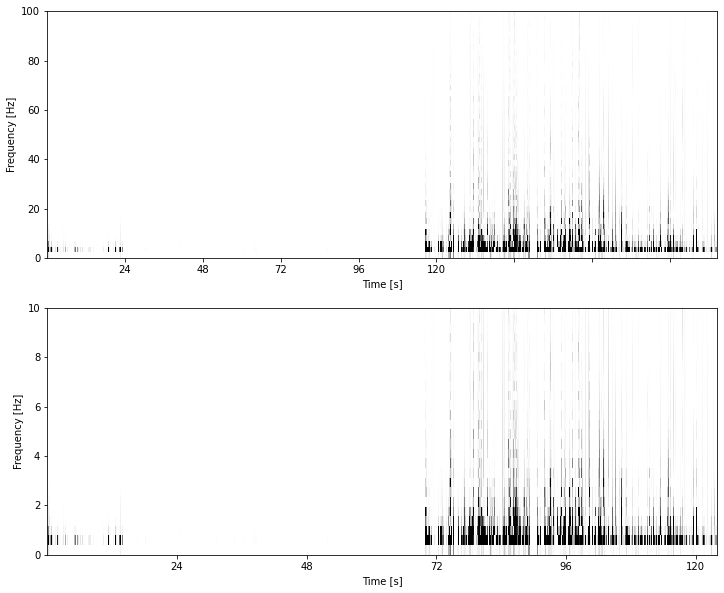

In [447]:
genthePlots(dfnonzero.iloc[:,1].values,dfnonzero.iloc[:,4].values,0,600,100,20,2,2)

(1059846,)
(1059846,)


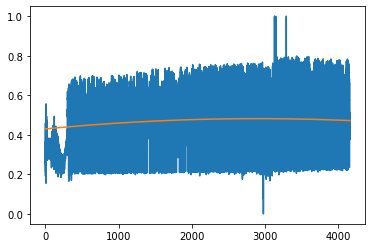

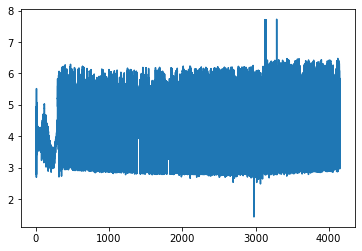

            2
-6.197e-09 x + 3.59e-05 x + 0.43
0
2
4
6
8
10
12
14
16
18
33470


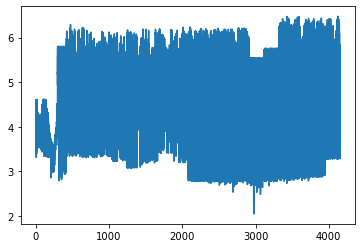

[[8.06543077e-05 3.78155622e-06 2.09580483e-05 ... 1.32151343e-06
  2.18405943e-07 1.57499467e-07]
 [3.13181571e-03 3.54151786e-04 6.67357683e-04 ... 7.95624892e-04
  8.21581881e-04 2.03496024e-03]
 [1.52904570e-03 1.59697183e-04 1.98123185e-04 ... 8.84757748e-05
  1.25615135e-04 1.68338603e-04]
 ...
 [4.06387640e-06 8.30600189e-06 5.86305695e-07 ... 1.14238632e-09
  1.73836053e-09 9.99242570e-09]
 [1.06609158e-05 4.32288891e-06 5.33628663e-06 ... 4.03474089e-08
  3.58027209e-08 4.34565938e-08]
 [2.02849218e-06 6.48158716e-06 1.07205319e-05 ... 5.13116267e-09
  3.70515196e-08 2.14538557e-09]]


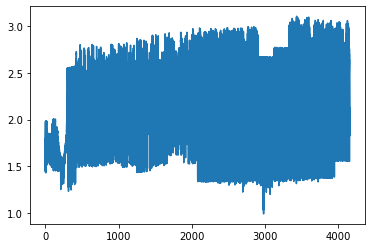

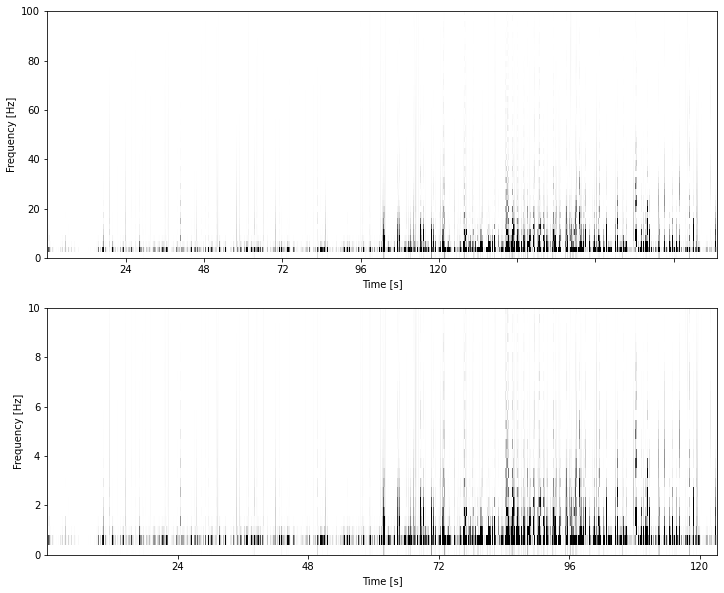

In [448]:
genthePlots(dfnonzero.iloc[:,1].values,dfnonzero.iloc[:,5].values,0,600,100,20,2,2)